# What is this notebook about

This notebook will be used to generate the masks for all the images, into a separate folder _mask, that is saved under the same directory as the rest of the raw train image files

Just run this code once and forget about it after, unless there is a problem with the masks

# Setup COLAB and imports

In [ ]:
# Used to reference the root directory, for directory traversal
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
mount_dir = '/content/gdrive'
root_dir = '/content/gdrive/My Drive/Colab Notebooks'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
! pip install rasterio
! pip install fiona

     |████████████████████████████████| 18.2MB 167kB/s 
     |████████████████████████████████| 14.7MB 210kB/s 


In [ ]:
import rasterio
from rasterio.mask import mask
from rasterio.plot import show, reshape_as_raster, reshape_as_image

from matplotlib import pyplot as plt
%matplotlib inline

import os
import fiona
import numpy as np
from pathlib import Path
from tqdm import tqdm 

# Global

In [ ]:
INSPECT_IDX = 0

In [ ]:
''' Masks are made using all the data, no subset required '''
PATH_DATA = Path(root_dir + '/spacenet6/spacenet6_data_BACKUP/train_all/AOI_11_Rotterdam')

PATH_GEOJSON = PATH_DATA/'geojson_buildings'
PATH_PAN = PATH_DATA/'PAN'
PATH_PSRGB = PATH_DATA/'PS-RGB'
PATH_PSRGBNIR = PATH_DATA/'PS-RGBNIR'
PATH_RGBNIR = PATH_DATA/'RGBNIR'
PATH_SAR = PATH_DATA/'SAR-Intensity'

PATH_MASK = PATH_DATA/'_mask'
PATH_MASK.mkdir(parents=True, exist_ok=True)

''' SET THE DESIRED DATA to use for creating the mask '''
PATH_IMAGE = PATH_PAN 

# Helper functions

#### Available functions
*   save_np_2d(array, fname)
*   generate_label(x)
*   plot_bands(bands, band_names, cmaps)
*   inspect_band(band)
*   inspect_tif(satdat)

#### Save a 2D numpy array to text file

In [ ]:
def save_np_2d(array, fname):
  fname = fname + '.txt'
  np.savetxt(PATH_DATA/fname, array, fmt="%s")
  print('saved')

#### Generate mask image file from geojson + tif.  Using a mask to cut raster along boundary

We only use PAN to simplify things, 1 channel to consider only

In [ ]:
# x in a running index for simplicity first
def generate_label(x):
  with fiona.open(PATH_GEOJSON/fnames_geojson[x]) as f:
    aoi = [feature['geometry'] for feature in f] 

  # crop=True crops the resulting raster to the AOI's bounding box
  with rasterio.open(PATH_IMAGE/fnames_img[x]) as img:
    if aoi == []: 
      # there is no building in the image
      clipped = np.zeros((1,900,900), dtype=np.uint16)
      transform = img.transform
    else:
      clipped, transform = mask(img, aoi, crop=False)

  # edit the pixel values to max 65535 as a mask - uint16 max value
  clipped[clipped > 0] = 65535

  # use the metadata from the original image
  meta = img.meta.copy()

  # update metadata with new clipped boundary
  meta.update({"transform": transform,
              "height": clipped.shape[1],
              "width": clipped.shape[2]
              })

  # write the clipped-and-cropped data to a new geotiff
  fname = fnames_geojson[x][:-8] + '.tif'

  with rasterio.open(PATH_MASK/fname, 'w', **meta) as dst:
    dst.write(clipped)

#### Used to visually display band data in images. Mass plots a total of four possible bands

In [ ]:
# example of input
    # bands: [red, green, blue, nir]
    # band_names: ['red', 'green', 'blue', 'nir']
    # cmaps: ['inferno', 'gist_earth', 'ocean', 'winter']
def plot_bands(bands, band_names, cmaps):
  fig = plt.figure(figsize=(16, 16))
  
  n = len(bands)
  for x in range(n):
    fig.add_subplot(2,2,x+1)
    plt.imshow(bands[x])

    if cmaps[x] != '': 
      plt.set_cmap(cmaps[x])
    plt.colorbar()
    plt.axis('off')
    plt.title(band_names[x])

  plt.show()

#### Used to inspect a specific band

In [ ]:
def inspect_band(band):
  # check the data type. We expect a numpy.ndarray
  print("Data type: {}".format(type(band)))

  # check the shape of the data, we expect 900x900 pixels for all images regardless of type
  print("Shape: {}".format(band.shape))

  # check dimensions. we expect 2 dimensions for a single band
  print("Dimensions: {}".format(band.ndim))

  # print out the band for sanity check
  print("Data: ")
  print(band)

#### Check out the various details of the tif file

In [ ]:
def inspect_tif(satdat):
  # check the geospatial boundary of this image file, the corners of the image
  print("Corners: {}\n".format(satdat.bounds))

  # getting dimensions, in map units of meters
  width = satdat.bounds.right - satdat.bounds.left
  height = satdat.bounds.top - satdat.bounds.bottom
  print("Width: {}, Height: {}\n".format(width, height))

  # getting pixel dimensions
  width_px = satdat.width
  height_px = satdat.height
  print("Pixels - Width: {}, Height: {}\n".format(width_px, height_px))

  # how many meters to a pixel
  width_ratio = width/width_px
  height_ratio = height/height_px
  print("m to px Ratio - Width: {}, Height: {}\n".format(width_ratio, height_ratio))

  # get coordinate reference system
  print("Coordinate Reference System: {}\n".format(satdat.crs))

  # Get coordinates of top left and bottom right points since there is a coordinate reference system attached to this file
  topleft = satdat.transform * (0,0)
  bottomright = satdat.transform * (width, height)

  print("Top left coordinates: {}, Bottom right coordinates: {}\n".format(topleft, bottomright))

  # get basic metadata of this geotif file
  print("Metadata of geotiff file")
  print(satdat.meta, '\n')     # can also use satdat.profile instead of satdat.meta

  # get number of bands by listing indices. count in the metadata refers to the number of bands
  print("Indexes: {}\n".format(satdat.indexes))

  # default view of the tif file
  print("Default view of tif file - for verification only\n")
  show(satdat)

# Prep work

### Inspect image files (PAN only for now)

In [ ]:
fnames_img = next(os.walk(PATH_IMAGE))[2]
fnames_img.sort()
print(len(fnames_img))
fnames_img[:3]

3401


['SN6_Train_AOI_11_Rotterdam_PAN_20190804111224_20190804111453_tile_8679.tif',
 'SN6_Train_AOI_11_Rotterdam_PAN_20190804111224_20190804111453_tile_8681.tif',
 'SN6_Train_AOI_11_Rotterdam_PAN_20190804111224_20190804111453_tile_8683.tif']

Corners: BoundingBox(left=592318.6201042183, bottom=5749422.410443312, right=592768.6142138068, top=5749872.4045529)

Width: 449.9941095885588, Height: 449.9941095886752

Pixels - Width: 900, Height: 900

m to px Ratio - Width: 0.49999345509839865, Height: 0.499993455098528

Coordinate Reference System: EPSG:32631

Top left coordinates: (592318.6201042183, 5749872.4045529), Bottom right coordinates: (592543.6142138453, 5749647.410443273)

Metadata of geotiff file
{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': 0.0, 'width': 900, 'height': 900, 'count': 1, 'crs': CRS.from_epsg(32631), 'transform': Affine(0.49999345509841014, 0.0, 592318.6201042183,
       0.0, -0.49999345509841014, 5749872.4045529)} 

Indexes: (1,)

Default view of tif file - for verification only



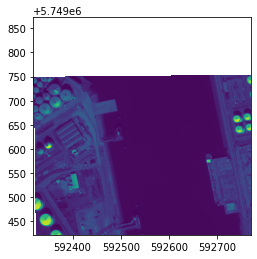

In [ ]:
satdat = rasterio.open(PATH_IMAGE/fnames_img[INSPECT_IDX])
inspect_tif(satdat)

In [ ]:
pan, = satdat.read()

# r, g, b, = satdat.read()
# inspect_band(r)
# inspect_band(g)
# inspect_band(b)

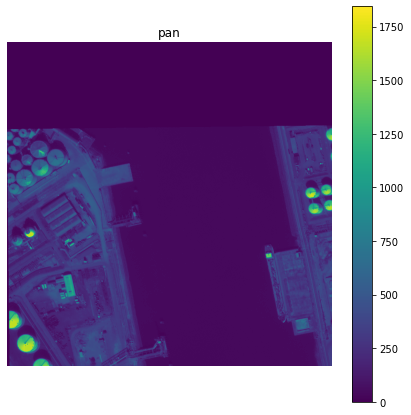

In [ ]:
plot_bands([pan], ['pan'], [''])

# plot_bands([r,g,b], ['r', 'g', 'b'], ['inferno', 'ocean', 'winter'])

### Prepare geojson files to create mask 

In [ ]:
fnames_geojson = next(os.walk(PATH_GEOJSON))[2]
fnames_geojson.sort()
print(len(fnames_geojson))
fnames_geojson[:3]

3401


['SN6_Train_AOI_11_Rotterdam_Buildings_20190804111224_20190804111453_tile_8679.geojson',
 'SN6_Train_AOI_11_Rotterdam_Buildings_20190804111224_20190804111453_tile_8681.geojson',
 'SN6_Train_AOI_11_Rotterdam_Buildings_20190804111224_20190804111453_tile_8683.geojson']

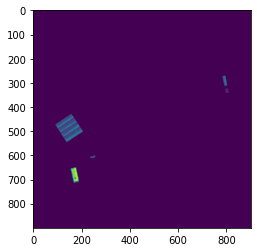

In [ ]:
with fiona.open(PATH_GEOJSON/fnames_geojson[INSPECT_IDX]) as f:
  aoi = [feature['geometry'] for feature in f] 

# crop=True crops the resulting raster to the AOI's bounding box
with rasterio.open(PATH_IMAGE/fnames_img[INSPECT_IDX]) as img:
  if aoi == []: 
    # there is no building in the image
    clipped = np.zeros((1,900,900), dtype=np.uint16)
    transform = img.transform
  else:
    clipped, transform = mask(img, aoi, crop=False)

show(clipped)

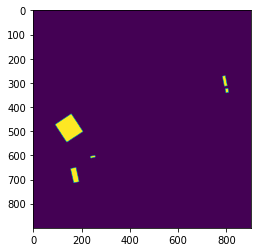

In [ ]:
# edit the pixel values to max 65535 as a mask - uint16 max value
clipped[clipped > 0] = 65535
show(clipped)

Labels generated
Corners: BoundingBox(left=592318.6201042183, bottom=5749422.410443312, right=592768.6142138068, top=5749872.4045529)

Width: 449.9941095885588, Height: 449.9941095886752

Pixels - Width: 900, Height: 900

m to px Ratio - Width: 0.49999345509839865, Height: 0.499993455098528

Coordinate Reference System: EPSG:32631

Top left coordinates: (592318.6201042183, 5749872.4045529), Bottom right coordinates: (592543.6142138453, 5749647.410443273)

Metadata of geotiff file
{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': 0.0, 'width': 900, 'height': 900, 'count': 1, 'crs': CRS.from_epsg(32631), 'transform': Affine(0.49999345509841014, 0.0, 592318.6201042183,
       0.0, -0.49999345509841014, 5749872.4045529)} 

Indexes: (1,)

Default view of tif file - for verification only



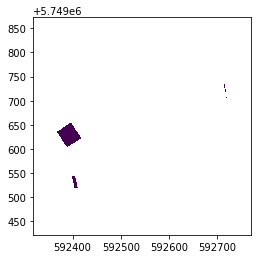

In [ ]:
# use the metadata from the original image
meta = img.meta.copy()

# update metadata with new clipped boundary
meta.update({"transform": transform,
            "height": clipped.shape[1],
            "width": clipped.shape[2]
            })

# write the clipped-and-cropped data to a new geotiff
fname = fnames_geojson[INSPECT_IDX][:-8] + '.tif'
fname = 'trial_mask'

clipped.shape
with rasterio.open(PATH_DATA/fname, 'w', **meta) as dst:
  dst.write(clipped)

print("Labels generated")

clipped_img = rasterio.open(PATH_DATA/fname)
inspect_tif(clipped_img)

# Generate masks

In [ ]:
for x, fname in tqdm(enumerate(fnames_geojson), total=len(fnames_geojson)):
  generate_label(x)

print("Masks generated")

Streaming output truncated to the last 5000 lines.

 14%|█▍        | 481/3401 [09:29<1:03:50,  1.31s/it]

 14%|█▍        | 482/3401 [09:30<1:02:38,  1.29s/it]

 14%|█▍        | 483/3401 [09:32<1:08:37,  1.41s/it]

 14%|█▍        | 484/3401 [09:34<1:11:47,  1.48s/it]

 14%|█▍        | 485/3401 [09:35<1:13:17,  1.51s/it]

 14%|█▍        | 486/3401 [09:37<1:13:34,  1.51s/it]

 14%|█▍        | 487/3401 [09:38<1:13:50,  1.52s/it]

 14%|█▍        | 488/3401 [09:40<1:14:07,  1.53s/it]

 14%|█▍        | 489/3401 [09:41<1:14:29,  1.53s/it]

 14%|█▍        | 490/3401 [09:43<1:14:00,  1.53s/it]

 14%|█▍        | 491/3401 [09:44<1:09:16,  1.43s/it]

 14%|█▍        | 492/3401 [09:45<1:06:40,  1.38s/it]

 14%|█▍        | 493/3401 [09:47<1:07:51,  1.40s/it]

 15%|█▍        | 494/3401 [09:48<1:05:27,  1.35s/it]

 15%|█▍        | 495/3401 [09:49<1:04:33,  1.33s/it]

 15%|█▍        | 496/3401 [09:50<1:02:38,  1.29s/it]

 15%|█▍        | 497/3401 [09:52<1:01:36,  1.27s/it]

 15%|█▍        | 498/3401 [09: